# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

Load our test image and see how it looks.

In [ ]:
# def get_image(path):
#     with open(os.path.abspath(path), 'rb') as f:
#         with Image.open(f) as img:
#             return img.convert('RGB')
#
# img = get_image('C:/Users/shorb/PycharmProjects/thesis/detect/image/covid_976.png')
# plt.imshow(img)

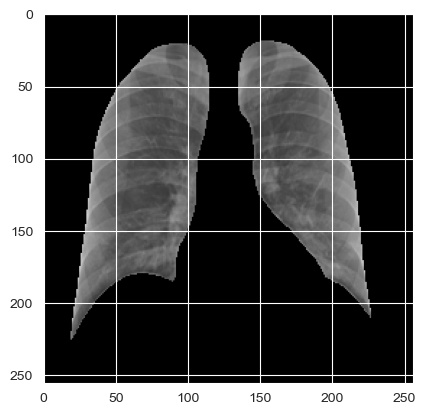

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def get_image(image_path, mask_path):
    with open(image_path, 'rb') as img_file:
        with Image.open(img_file) as img:
            img = img.convert('RGB')

    # Load and preprocess the lung mask
    with open(mask_path, 'rb') as mask_file:
        with Image.open(mask_file) as mask:
            mask = mask.convert('L')

    # Ensure that the mask and image have the same size
    mask = mask.resize(img.size, Image.BILINEAR)

    # Apply the mask to the image
    img_with_mask = Image.new('RGB', img.size)
    img_with_mask.paste(img, mask=mask)

    return img_with_mask

# Define paths to the image and mask
image_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/image/covid_976.png'
mask_path = 'C:/Users/shorb/PycharmProjects/thesis/detect/mask/covid_976.png'

# Get the image with the merged mask
img = get_image_with_mask(image_path, mask_path)

# Display the image with the merged mask
plt.imshow(img)
plt.show()

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [ ]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


class Ensemble(nn.Module):
    def __init__(self, num_classes):
        super(Ensemble, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        self.vgg16 = models.vgg16(pretrained=True)
        self.inception = models.inception_v3(pretrained=True)

        # Modify the last fully connected layer of each model
        self.resnet18.fc = nn.Linear(512, num_classes)
        self.vgg16.classifier[6] = nn.Linear(4096, num_classes)
        self.inception.fc = nn.Linear(2048, num_classes)

        # Remove the auxiliary layer of Inception-v3
        self.inception.aux_logits = False

    def forward(self, x):
        resnet_output = self.resnet18(x)
        vgg_output = self.vgg16(x)
        inception_output = self.inception(x)

        ensemble_output = (resnet_output + vgg_output + inception_output) / 3

        return ensemble_output


# Define the number of classes in your dataset
num_classes = 3

# Create an instance of the Ensemble model
hybrid_ensemble = Ensemble(num_classes)


# # Example usage
# input_tensor = torch.randn(1, 3, 299, 299)  # Example input tensor
# output = hybrid_ensemble(input_tensor)
# print(output.shape)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hybrid_ensemble.parameters(), lr=0.05e-5, weight_decay=5e-5)


C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date w

Load the pretrained model for Resnet50 available in Pytorch.

In [ ]:
model_path = 'C:/Users/shorb/PycharmProjects/thesis/metric/Ensamble/shom/Ensemble_full.pth'
class_names = ['normal', 'covid', 'non-covid']

# Load the saved model (on CPU)
model = torch.load(model_path)


Load label texts for ImageNet predictions so we know what model is predicting

In [ ]:
class_idx = ['normal', 'covid', 'non-covid']
idx2label = {k: v[1] for k, v in enumerate(class_idx)}
cls2label = {v[0]: v[1] for v in enumerate(class_idx)}
cls2idx = {v[0]: k for k, v in enumerate(class_idx)}


Get the predicition for our image.

In [ ]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Move the input tensor to the GPU
    img_t = img_t.cuda()
    # Move the model to the GPU
    model = model.cuda()

# Now, you can use the model for inference
model.eval()
logits = model(img_t)


Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [ ]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(1)

# Move the tensors to CPU and convert to NumPy arrays
probs_cpu = probs5[0][0].cpu().detach().numpy()
class_indices_cpu = probs5[1][0].cpu().detach().numpy()

# Create a list of tuples
result = [(p, c, idx2label[c]) for p, c in zip(probs_cpu, class_indices_cpu)]


We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [ ]:
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [ ]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

Import lime and create explanation for this prediciton.

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

In [ ]:
from skimage.segmentation import mark_boundaries

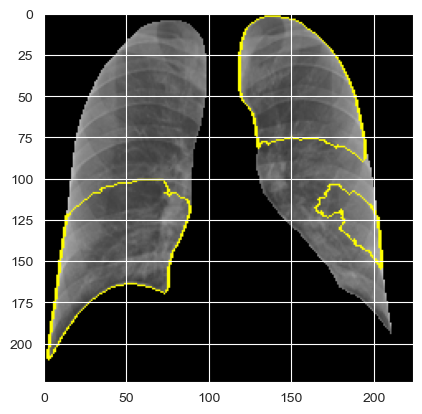

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

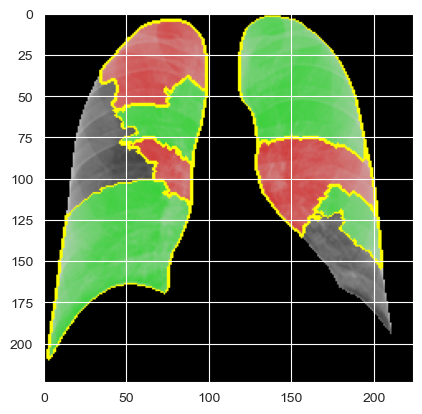

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [ ]:
import numpy as np

# Assuming img_boundry1 and img_boundry2 are binary images where 1 represents infected areas
infected_pixels1 = np.sum(img_boundry1 > 0)
infected_pixels2 = np.sum(img_boundry2 > 0)

# Total number of pixels in the lung area (assuming lung area is defined by the mask)
total_lung_pixels = np.sum(img)

# Calculate the percentage of lung area infected for both img_boundry1 and img_boundry2
percentage_infected1 = (infected_pixels1 / total_lung_pixels) * 100
percentage_infected2 = (infected_pixels2 / total_lung_pixels) * 100

print(f'Percentage of lung area infected (img_boundry1): {percentage_infected1:.2f}%')
print(f'Percentage of lung area infected (img_boundry2): {percentage_infected2:.2f}%')


Percentage of lung area infected (img_boundry1): 0.97%
Percentage of lung area infected (img_boundry2): 0.96%
